# MRMS Precipitation Plots
By: Ty Janoski

## Setup

In [3]:
# import statements

import gzip
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from io import BytesIO
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from metpy.plots import ctables
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import scienceplots  # noqa: F401
import pandas as pd

plt.style.use(["science","nature"])
plt.rcParams["text.usetex"] = True


In [4]:
# Make the above code into a function
def read_in_mrms_data(bucket_name: str, path: str, hour: str) -> xr.DataArray:
    # Set up S3 client
    s3 = boto3.client(
        "s3", region_name="us-east-1", config=Config(signature_version=UNSIGNED)
    )

    # List objects from AWS Bucket
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=path)

    # Find key containing hour.grib2.gz, which is the file we want
    for obj in response["Contents"]:
        if f"{hour}.grib2.gz" in obj["Key"]:
            key = obj["Key"]
            break

    # Read in the file
    grib_data = BytesIO()
    s3.download_fileobj(bucket_name, key, grib_data)
    grib_data.seek(0)

    with tempfile.NamedTemporaryFile(suffix=".grib2", delete=False) as tmp_file:
        with gzip.open(grib_data, "rb") as f:
            tmp_file.write(f.read())
        tmp_file_path = tmp_file.name

        
        da = xr.open_dataarray(tmp_file_path, engine="cfgrib")

    return da
    

In [5]:
# Read in 0100-0200 UTC hourly rainfall and the
# 24-hour accumulated rainfall for 1200-1200 UTC 1-2 September 2021

# Set bucket name
bucket_name = "noaa-mrms-pds"

# Read in rainfall
hourly = read_in_mrms_data(
    bucket_name, "CONUS/MultiSensor_QPE_01H_Pass2_00.00/20210902/", "020000"
)
daily = read_in_mrms_data(
    bucket_name, "CONUS/MultiSensor_QPE_24H_Pass2_00.00/20210902/", "120000"
)

dates = ["1", "2", "2"]
times = ["230039", "000039", "010038"]
# Read in composite reflectivity
refl = xr.concat(
    [
        read_in_mrms_data(
            bucket_name,
            "CONUS/MergedReflectivityQCComposite_00.50/2021090" + d + "/",
            t,
        )
        for d, t in zip(dates, times)
    ],
    dim="time",
)


/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(39) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(39) ignored
/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarnin

In [6]:
# Read in any WoFS simulation to get some projection attrs
wofs = xr.open_dataset("/mnt/drive2/new-wofs/20Z/wofs_ALL_43_20210901_2000_2335.nc")
wofs_lat = wofs.xlat
wofs_lon = wofs.xlon

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs.attrs["CEN_LON"],
    central_latitude=wofs.attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)

# latitude and longitude
lat = hourly.latitude
lon = hourly.longitude

refl_lat = refl.latitude
refl_lon = refl.longitude

# Get MetPy ctable for precip
precip_cmap = ctables.registry.get_colortable("precipitation")
refl_cmap = ctables.registry.get_colortable("NWSReflectivity")


In [7]:
# Load the HURDAT2 file
file_path = "hurdat2.csv"  # Update with actual path
with open(file_path, "r") as f:
    lines = f.readlines()

# Find the start of Hurricane Ida (2021) using its unique storm ID
ida_start = None
for i, line in enumerate(lines):
    if line.startswith("AL092021,") and "IDA" in line:  # Match the storm ID and name
        ida_start = i
        break

# Extract Hurricane Ida's data block
ida_lines = []
for i in range(ida_start + 1, len(lines)):
    if lines[i][0].isalpha():  # Stop at the next storm entry
        break
    ida_lines.append(lines[i].strip())

# Convert to DataFrame
columns = [
    "Date", "Time", "Record ID", "Status", "Latitude", "Longitude",
    "Max Wind (kt)", "Min Pressure (mb)"
]
ida_data = [line.split(",")[:8] for line in ida_lines]
df_ida = pd.DataFrame(ida_data, columns=columns)

# Convert latitude/longitude to float
def convert_lat_lon(lat, lon):
    lat_val = float(lat[:-1]) * (-1 if lat[-1] == "S" else 1)
    lon_val = float(lon[:-1]) * (-1 if lon[-1] == "W" else 1)
    return lat_val, lon_val

df_ida["Latitude"], df_ida["Longitude"] = zip(
    *df_ida.apply(lambda row: convert_lat_lon(row["Latitude"].strip(), row["Longitude"].strip()), axis=1)
)


# Keep only necessary columns
df_ida = df_ida[["Date", "Time", "Latitude", "Longitude"]]

In [8]:
# Read in aoi file
aoi = xr.open_dataarray("../data-holding/aoi.nc")

## Plots

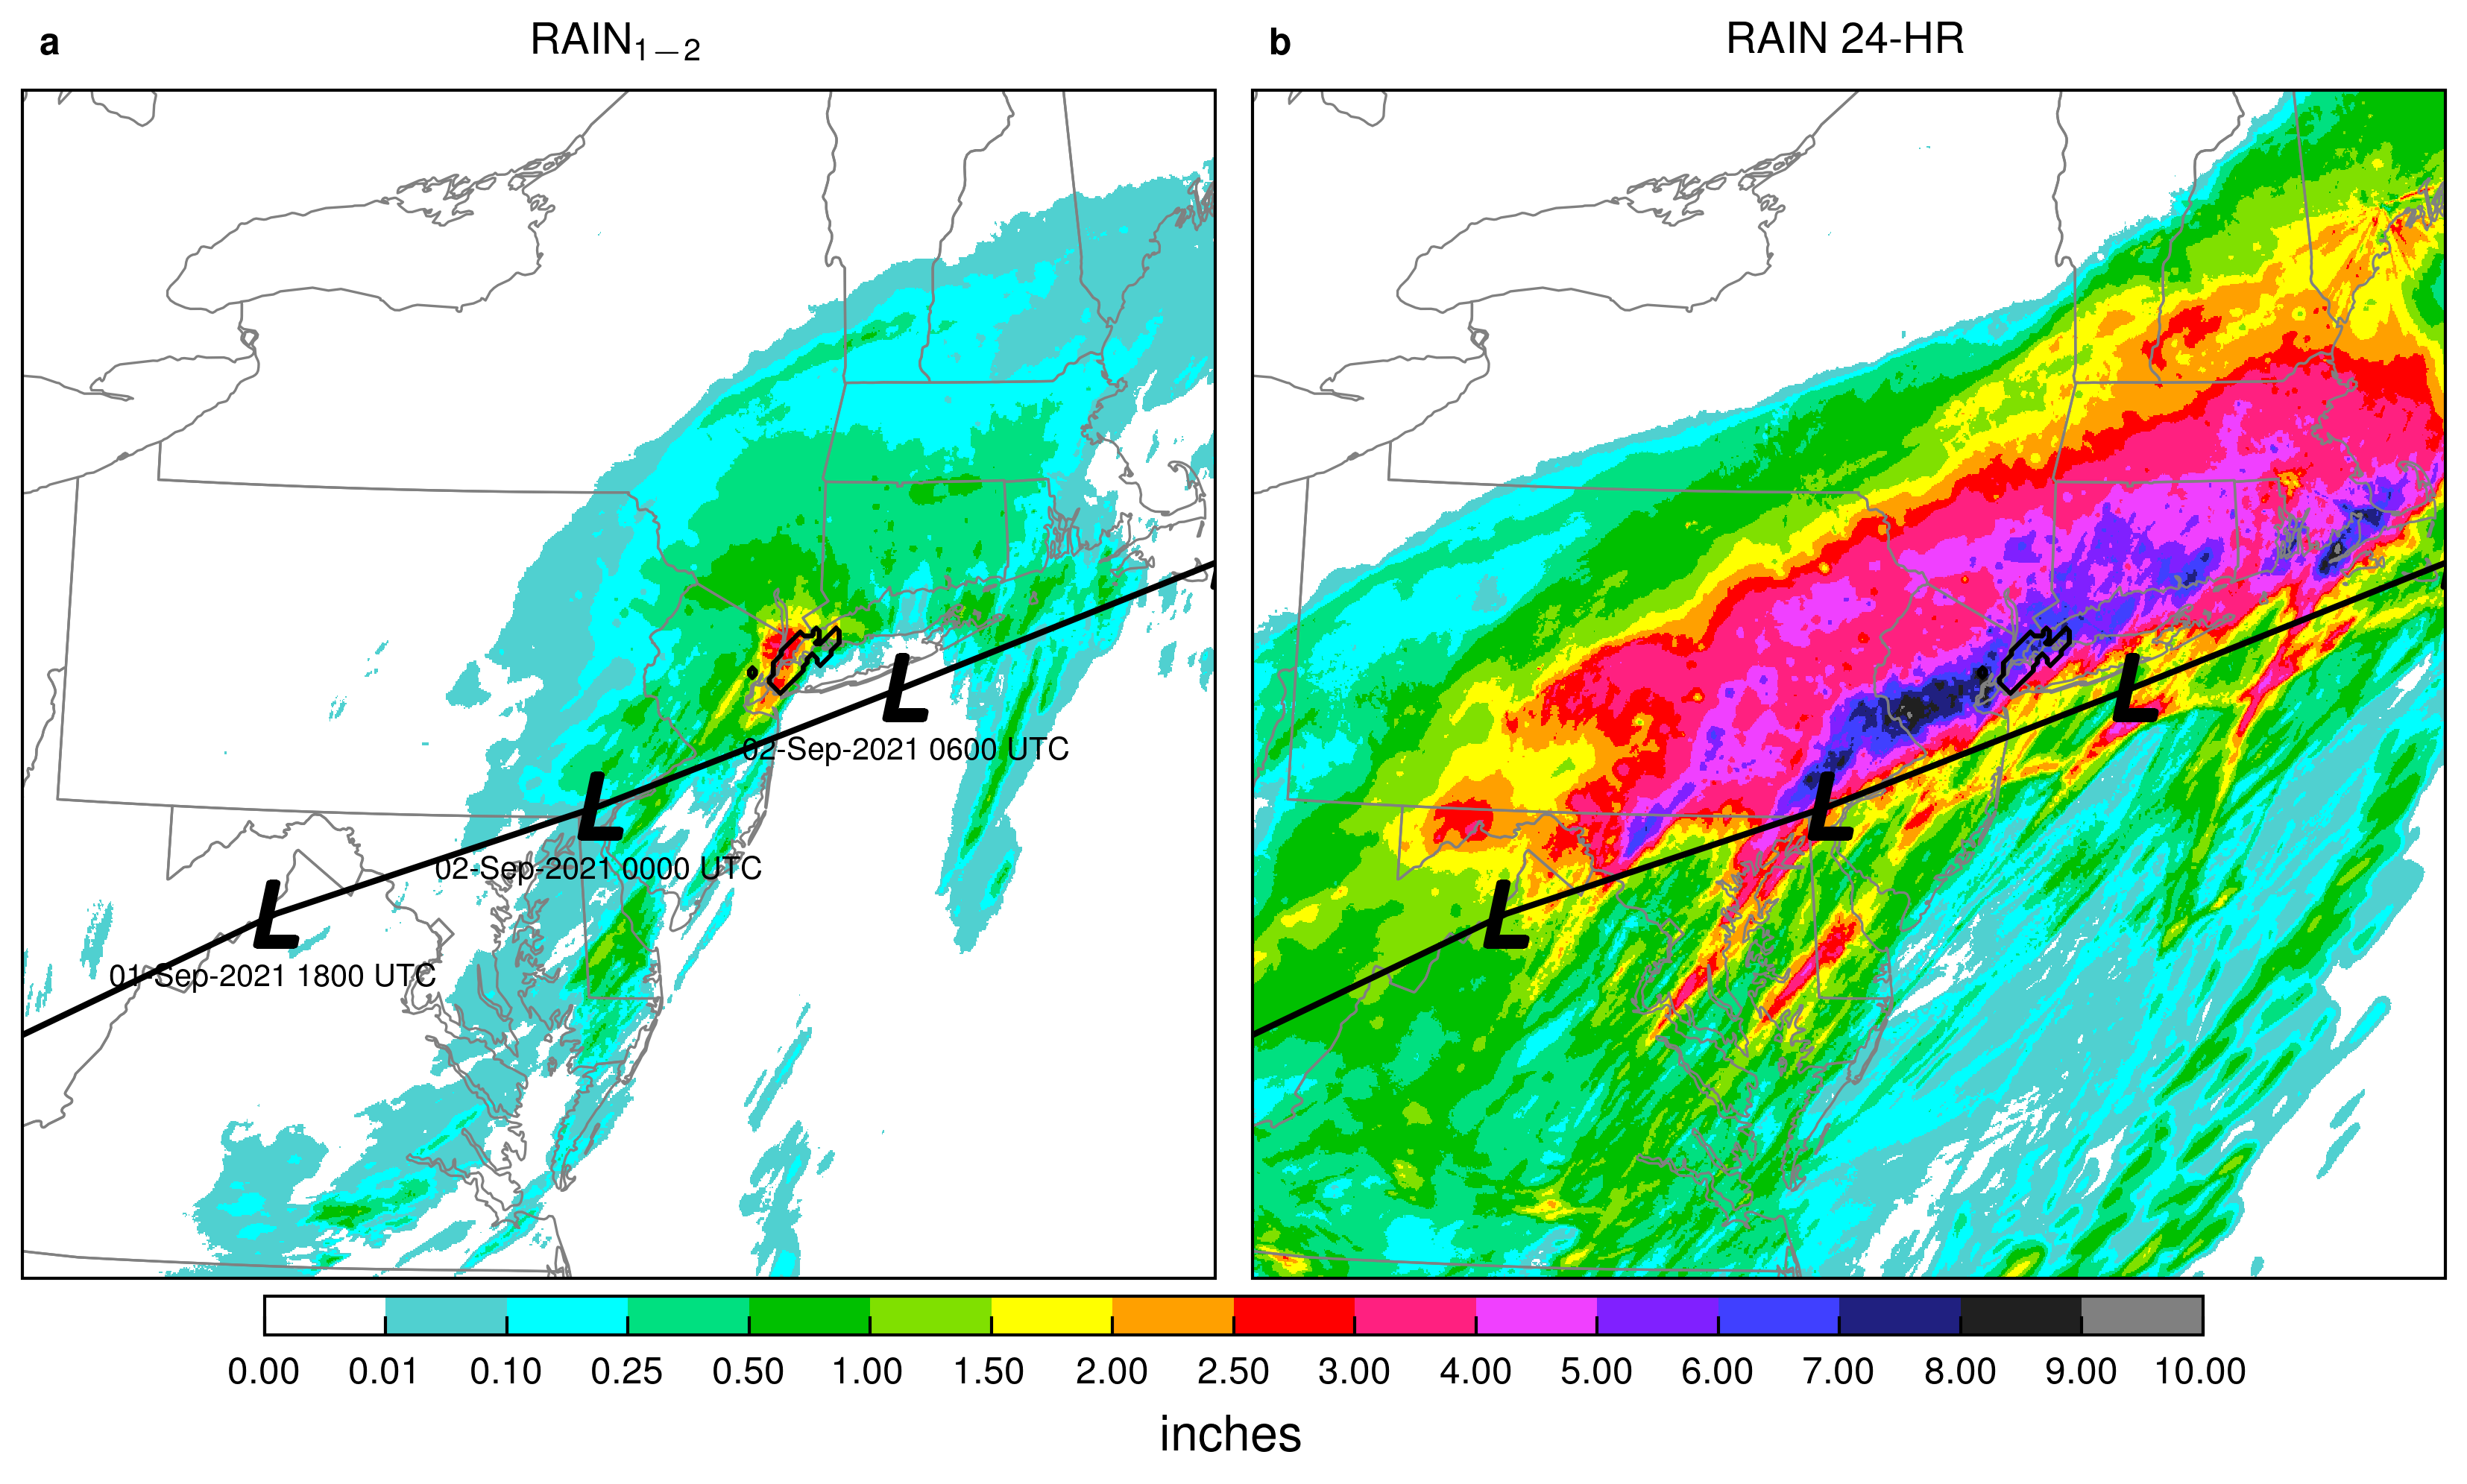

In [9]:
# Set levels
levels = [0, 0.01, 0.1, 0.25, 0.50, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]

titles = ["RAIN$_{1-2}$", "RAIN 24-HR"]

letters = ["a", "b"]

# Create a normalization object
norm = mcolors.BoundaryNorm(levels, ncolors=len(levels) - 1, clip=False)

# List of hourly and daily
to_plot = [hourly, daily]

# Make a plot of the hourly rainfall
fig, axes = plt.subplots(
    1,
    2,
    figsize=(5.5, 3.2),
    dpi=600,
    subplot_kw={"projection": proj},
    layout="constrained",
)

for i,ax in enumerate(axes):
   
    ax.set_extent(  # type: ignore
        [
            -449900.09156094893,
            449900.51654555957,
            -447909.5438942791,
            448284.39736015256,
        ],
        crs=proj,
    )

    pc = ax.pcolormesh(
        lon,
        lat,
        to_plot[i] / 25.4,
        norm=norm,
        transform=ccrs.PlateCarree(),
        cmap=precip_cmap,  # type: ignore
    )

    ax.add_feature(cfeature.STATES, linewidth=0.4, edgecolor="gray")  # type: ignore

    # Add the AOI
    ax.contour(
        wofs_lon,
        wofs_lat,
        aoi.values,
        levels=[0, 0.5, 1],
        colors=["black"],
        transform=ccrs.PlateCarree(),
        zorder=3,
        linewidths=[0.5],
    )

    ax.text(
        0.015, 1.03, r"\textbf{" + letters[i] + "}", transform=ax.transAxes, fontsize=6
    )

    ax.set_title(titles[i], fontsize=7)

    ax.plot(
        df_ida["Longitude"],
        df_ida["Latitude"],
        color="k",
        marker="$L$",
        markersize=10,
        transform=ccrs.PlateCarree(),
    )

    # Get map extent (xmin, xmax, ymin, ymax)
    x_min, x_max, y_min, y_max = ax.get_extent(crs=ccrs.PlateCarree())

    # Add date & time below the "L" markers (only in the first subplot)
    if i == 0:
        for x, y, date, time in zip(df_ida["Longitude"], df_ida["Latitude"], df_ida["Date"], df_ida["Time"]):
            if x_min <= x <= x_max-1 and y_min <= y <= y_max:
                ax.text(
                    x,
                    y - 0.35,  # Adjust to position below "L"
                    f"{date[6:]}-Sep-{date[:4]} {time[:]} UTC",
                    fontsize=5,
                    color="k",
                    transform=ccrs.PlateCarree(),
                    ha="center",
                    va="top",
                )

# Add colorbar to figure
cb = fig.colorbar(
    pc, ax=axes, orientation="horizontal", pad=0.01, aspect=50, shrink=0.8
)
cb.set_ticks(levels)
cb.set_label("inches", fontsize=8)
cb.ax.tick_params(labelsize=6)

# Save fig as pdf
# plt.savefig("../final-figures/Fig1_mrms_rainfall.pdf", bbox_inches="tight")

# Show figure
plt.show()


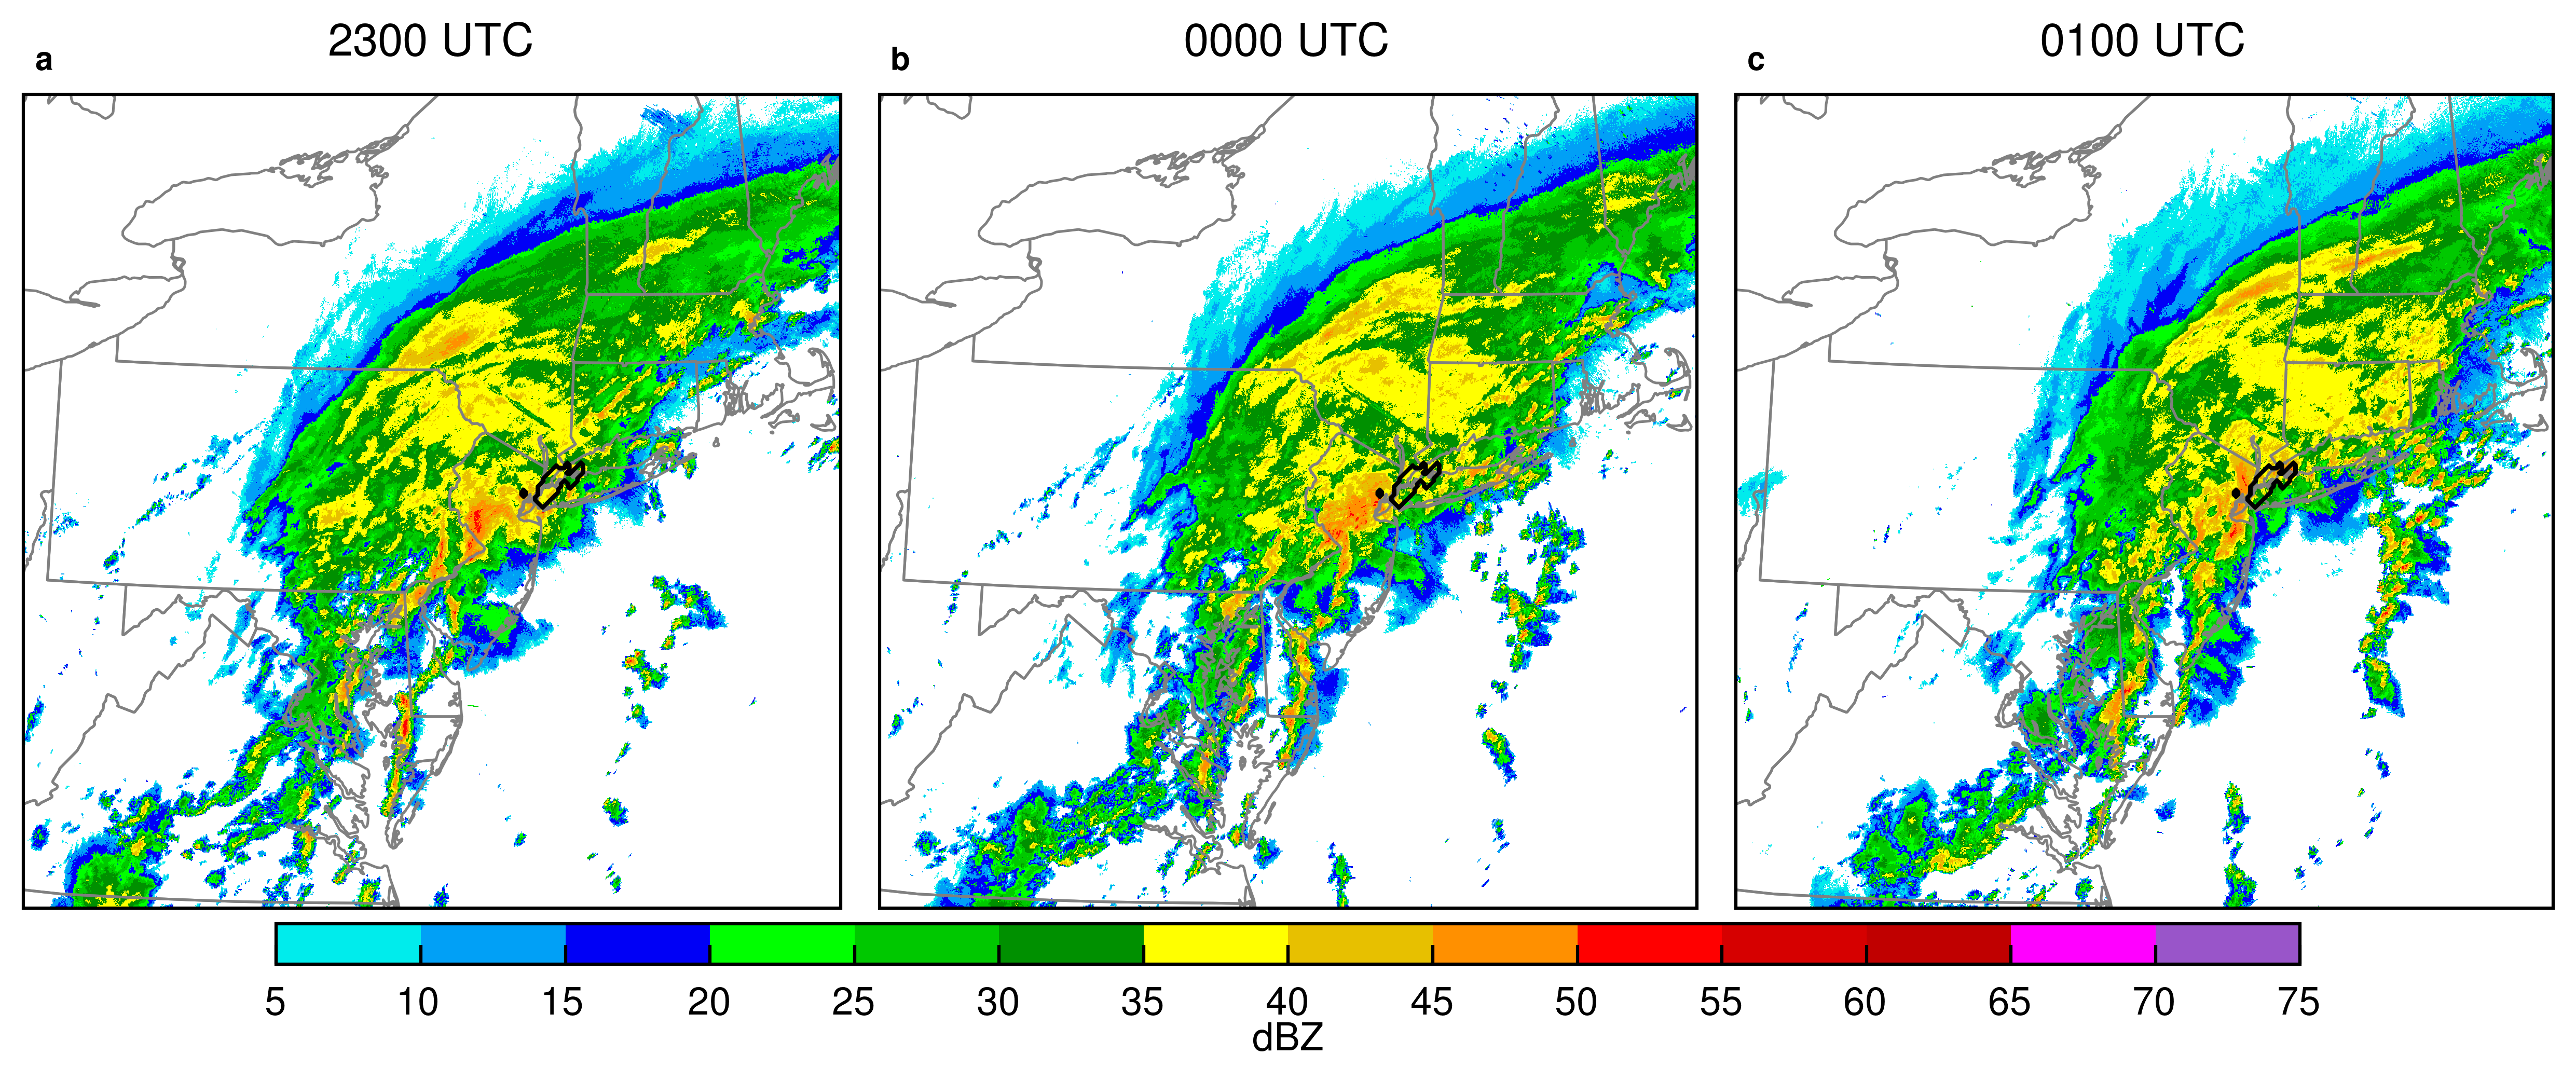

In [12]:
# Restrict reflectivity to a smaller area and mask values below 5 dBZ
refl_masked = refl.where((abs(refl_lon - 285) < 10) & (abs(refl_lat - 40) < 8), drop=True).where(refl > 5)

# Set levels
levels = range(5, 76, 5)
letters = ["a", "b", "c"]

titles = ["2300 UTC", "0000 UTC", "0100 UTC"]

# Create a normalization object
norm = mcolors.BoundaryNorm(levels, ncolors=len(levels) - 1, clip=False)

# Make a plot of the hourly rainfall
fig, axes = plt.subplots(
    1,
    3,
    figsize=(5.5, 3),
    dpi=900,
    subplot_kw={"projection": proj},
    layout="constrained",
)

for i, ax in enumerate(axes):
    ax.set_extent(  # type: ignore
        [
            -449900.09156094893,
            449900.51654555957,
            -447909.5438942791,
            448284.39736015256,
        ],
        crs=proj,
    )

    pc = xr.plot.pcolormesh( # type: ignore
        refl_masked[i, :, :],
        ax=ax,
        norm=norm,
        transform=ccrs.PlateCarree(),
        cmap=refl_cmap,
        extend="neither",
        add_colorbar=False,
    )

    # Add the AOI
    ax.contour(
        wofs_lon,
        wofs_lat,
        aoi.values,
        levels=[0, 0.5, 1],
        colors=["black"],
        transform=ccrs.PlateCarree(),
        zorder=3,
        linewidths=[0.5],
    )

    ax.add_feature(cfeature.STATES, linewidth=0.4, edgecolor="gray")
    ax.set_title(titles[i], fontsize=7)

    ax.text(
        0.015, 1.03, r"\textbf{" + letters[i] + "}", transform=ax.transAxes, fontsize=5
    )

# Add colorbar to figure
cb = fig.colorbar(
    pc, ax=axes, orientation="horizontal", pad=0.01, aspect=50, shrink=0.8
)
cb.set_ticks(levels)
cb.set_label("dBZ", fontsize=6, labelpad=0.01)
cb.ax.tick_params(labelsize=6)

plt.show()
